# 이미지 로드 및 전처리하기

이 튜토리얼에서는 세 가지 방법으로 이미지 데이터세트를 로드하고 전처리하는 방법을 보여줍니다.

- 먼저 고급 Keras 사전 처리 유틸리티(예: `tf.keras.utils.image_dataset_from_directory`) 및 레이어(예: `tf.keras.layers.Rescaling`)를 사용하여 디스크에서 이미지 디렉터리를 읽습니다.
- 다음으로 [tf.data를 사용하여](../../guide/data.ipynb) 처음부터 고유한 입력 파이프라인을 작성합니다.
- 마지막으로 [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview)에서 사용할 수 있는 대규모 [카탈로그](https://www.tensorflow.org/datasets)에서 데이터세트를 다운로드합니다.
- 설치 : pip install tensorflow-datasets

Tensorflow 홈페이지 코드 : https://www.tensorflow.org/tutorials/images/classification

## 설정

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
print(tf.__version__)

2.9.2


### 꽃 데이터세트 다운로드하기

이 튜토리얼은 수천 장의 꽃 사진 데이터세트를 사용합니다. 꽃 데이터세트에는 클래스당 하나씩 5개의 하위 디렉터리가 있습니다.

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

참고: 모든 이미지에는 CC-BY 라이선스가 있으며 크리에이터는 LICENSE.txt 파일에 나열됩니다.

In [7]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

다운로드한 후 (218MB), 이제 꽃 사진의 사본을 사용할 수 있습니다. 총 3670개의 이미지가 있습니다.

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


각 디렉토리에는 해당 유형의 꽃 이미지가 포함되어 있습니다. 다음은 장미입니다.

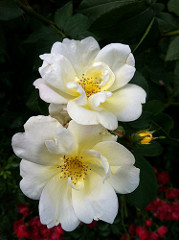

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

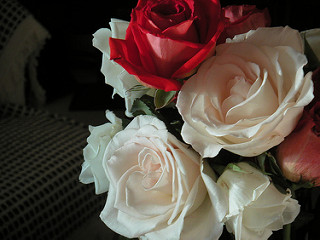

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Keras 유틸리티를 사용하여 데이터 로드

유용한 `tf.keras.utils.image_dataset_from_directory` 유틸리티를 사용하여 디스크에서 이러한 이미지를 로드해 보겠습니다.

### 데이터세트 만들기

로더를 위해 일부 매개변수를 정의합니다.

In [11]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 이미지의 80%를 훈련에 사용하고 20%를 유효성 검사에 사용합니다.

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다.

In [16]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 시각화하기

다음은 훈련 데이터세트의 처음 9개 이미지입니다.

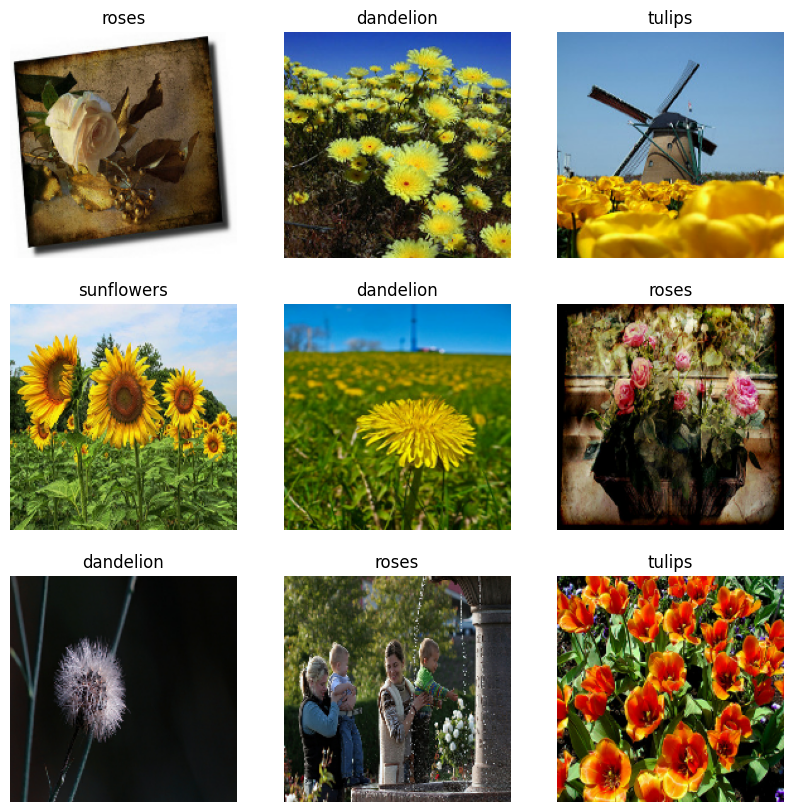

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이러한 데이터세트를 사용하는 모델을 `model.fit`(이 튜토리얼의 뒷부분에 표시)에 전달하여 모델을 훈련할 수 있습니다. 원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있습니다.

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`는 `(32, 180, 180, 3)` 형상의 텐서이며, `180x180x3` 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.

이들 텐서 중 하나에서 `.numpy()`를 호출하여 `numpy.ndarray`로 변환할 수 있습니다.

### 데이터 표준화하기


RGB 채널 값은 `[0, 255]` 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다.

여기에서 `tf.keras.layers.Rescaling`을 사용하여 값을 `[0, 1]` 범위로 표준화합니다.

In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있습니다. `Dataset.map`을 호출하여 데이터세트에 이를 적용할 수 있습니다.

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근법을 사용할 것입니다.

참고: 픽셀 값을 `[-1,1]`로 조정하려면 대신 `tf.keras.layers.Rescaling(1./127.5, offset=-1)`을 작성할 수 있습니다.

참고: 이전에 `tf.keras.utils.image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 해당 모델에도 크기 조정 논리를 포함하려면 `tf.keras.layers.Resizing` 레이어를 사용할 수 있습니다.

### 성능을 위한 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

- `Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.
- `Dataset.prefetch`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

관심 있는 독자는 <a>tf.data API를 통한 성능 향상</a> 가이드의 <em>프리페치</em> 섹션에서 두 가지 메서드와 데이터를 디스크에 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 모델 훈련하기

완성을 위해 방금 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줍니다.

[순차](https://www.tensorflow.org/guide/keras/sequential_model) 모델은 각각에 최대 풀링 레이어(`tf.keras.layers.MaxPooling2D`)가 있는 세 개의 컨볼루션 블록(`tf.keras.layers.Conv2D`)으로 구성됩니다. ReLU 활성화 함수(`'relu'`)에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(`tf.keras.layers.Dense`)가 있습니다. 이 모델은 어떤 식으로든 조정되지 않았습니다. 목표는 방금 만든 데이터세트를 사용하여 역학을 보여주는 것입니다. 이미지 분류에 대해 자세히 알아보려면 [이미지 분류](../images/classification.ipynb) 튜토리얼을 방문하세요.

In [22]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

`tf.keras.optimizers.Adam` 옵티마이저 및 `tf.keras.losses.SparseCategoricalCrossentropy` 손실 함수를 선택합니다. 각 훈련 epoch에 대한 훈련 및 검증 정확도를 보려면 `metrics` 인수를 `Model.compile`에 전달하세요.

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

참고: 몇 개의 epoch에 대해서만 훈련하므로 이 튜토리얼은 빠르게 진행됩니다. 

In [24]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 9s 30ms/step - loss: 1.3176 - accuracy: 0.4506 - val_loss: 1.1261 - val_accuracy: 0.5722
Epoch 2/3
92/92 [==============================] - 2s 19ms/step - loss: 1.0381 - accuracy: 0.5879 - val_loss: 0.9955 - val_accuracy: 0.6349
Epoch 3/3
92/92 [==============================] - 2s 19ms/step - loss: 0.8786 - accuracy: 0.6580 - val_loss: 0.9671 - val_accuracy: 0.6294


참고: `Model.fit`을 사용하는 대신 사용자 지정 훈련 루프를 작성할 수도 있습니다. 자세히 알아보려면 [처음부터 훈련 루프 작성하기](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) 튜토리얼을 방문하세요.

검증 정확도가 훈련 정확도에 비해 낮으므로 모델이 과대적합되었음을 알 수 있습니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)에서 과대적합 및 이를 줄이는 방법에 대해 자세히 알아볼 수 있습니다.

## 미세 제어를 위해 `tf.data` 사용하기

위의 Keras 전처리 유틸리티 `tf.keras.utils.image_dataset_from_directory`는 이미지 디렉터리에서 `tf.data.Dataset`을 생성하는 편리한 방법입니다.

더 세밀한 제어를 위해 `tf.data`를 사용하여 고유한 입력 파이프라인을 작성할 수 있습니다. 이 섹션에서는 이전에 다운로드한 TGZ 파일의 파일 경로부터 시작하여 이를 수행하는 방법을 보여줍니다.

In [27]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [28]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\khkim\\.keras\\datasets\\flower_photos\\daisy\\14332947164_9b13513c71_m.jpg'
b'C:\\Users\\khkim\\.keras\\datasets\\flower_photos\\tulips\\4589624702_b6baa83699_m.jpg'
b'C:\\Users\\khkim\\.keras\\datasets\\flower_photos\\tulips\\18270448366_d5676dec64_z.jpg'
b'C:\\Users\\khkim\\.keras\\datasets\\flower_photos\\roses\\16476788181_0e2ffc719a.jpg'
b'C:\\Users\\khkim\\.keras\\datasets\\flower_photos\\sunflowers\\22405882322_d4561f8469_n.jpg'


파일의 트리 구조를 사용하여 `class_names` 목록을 컴파일할 수 있습니다.

In [29]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


데이터세트를 학습 및 검증 세트로 분할합니다.

In [30]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

다음과 같이 각 데이터세트의 길이를 인쇄할 수 있습니다.

In [31]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


파일 경로를 `(img, label)` 쌍으로 변환하는 간단한 함수를 작성합니다.

In [ ]:

# Convert the path to a list of path components
parts = tf.strings.split(file_path, os.path.sep)
# The second to last is the class-directory
one_hot = parts[-2] == class_names
# Integer encode the label
return tf.argmax(one_hot)

In [32]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [33]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [34]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

`Dataset.map`을 사용하여 `image, label` 쌍의 데이터세트를 작성합니다.

In [35]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [36]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


### 성능을 위한 데이터세트 구성하기

이 데이터세트로 모델을 훈련하려면 데이터에 대해 다음이 필요합니다.

- 잘 섞는다.
- 배치 처리한다.
- 가능한 빨리 배치를 사용할 수 있어야 한다.

이러한 기능은 `tf.data` API를 사용하여 추가할 수 있습니다. 자세한 내용은 [입력 파이프 라인 성능](../../guide/performance/datasets.ipynb) 가이드를 참조하세요.

In [37]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### 데이터 시각화하기

이 데이터세트를 이전에 작성한 데이터 세트와 유사하게 시각화할 수 있습니다.

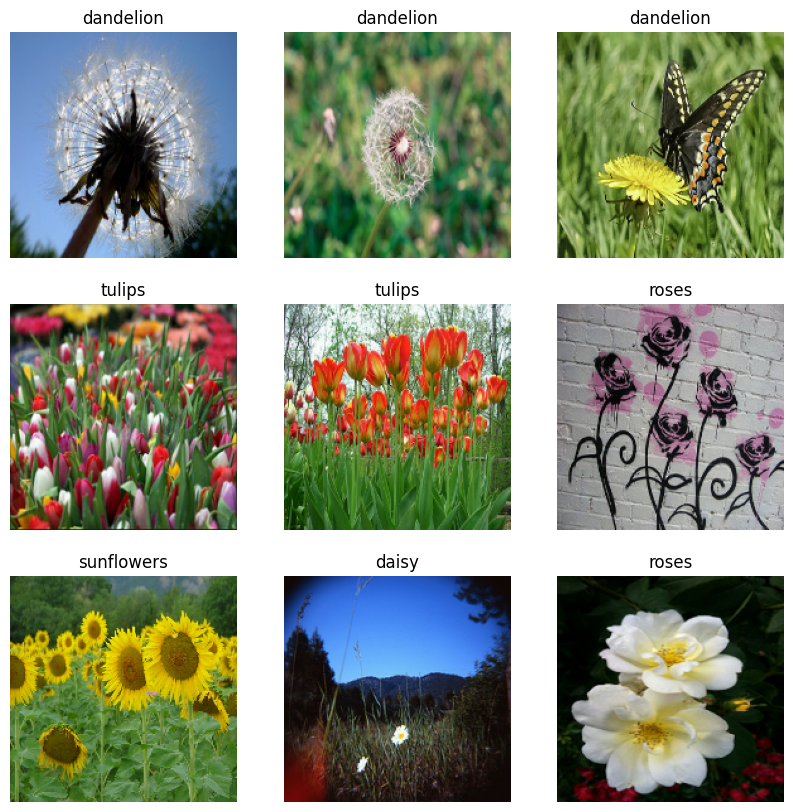

In [38]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### 모델 계속 훈련하기

이제 위의 `tf.keras.utils.image_dataset_from_directory`에 의해 생성된 것과 유사한 `tf.data.Dataset`을 수동으로 구축했습니다. 이를 사용하여 모델을 계속 학습할 수 있습니다. 이전과 마찬가지로 실행 시간을 짧게 유지하기 위해 몇 epoch 동안만 훈련합니다.

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

## TensorFlow 데이터세트 사용하기

지금까지 이 튜토리얼은 디스크에서 데이터를 로드하는 데 중점을 두었습니다. [TensorFlow Datasets](https://www.tensorflow.org/datasets)에서 다운로드하기 쉬운 대규모 데이터세트 [카탈로그](https://www.tensorflow.org/datasets/catalog/overview)를 탐색하여 사용할 데이터세트를 찾을 수도 있습니다.

이전에 디스크에서 꽃 데이터세트를 로드했으므로 이제 TensorFlow 데이터세트로 가져오겠습니다.

TensorFlow 데이터세트를 사용하여 꽃 [데이터세트](https://www.tensorflow.org/datasets/catalog/tf_flowers)를 다운로드합니다.

In [39]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]
Generating splits...:   0%|                                        | 0/1 [00:00<?, ? splits/s]
Generating train examples...: 0 examples [00:00, ? examples/s]
Generating train examples...: 315 examples [00:00, 3118.85 examples/s]
Generating train examples...: 627 examples [00:00, 3048.11 examples/s]
Generating train examples...: 932 examples [00:00, 2892.70 examples/s]
Generating train examples...: 1223 examples [00:00, 2763.19 examples/s]
Generating train examples...: 1510 examples [00:00, 2790.06 examples/s]
Generating train examples...: 1804 examples [00:00, 2838.98 examples/s]
Generating train examples...: 2090 examples [00:00, 2845.61 examples/s]
Generating train examples...: 2422 examples [00:00, 2984.47 examples/s]
Generating train examples...: 2760 examples [00:00, 3106.17 examples/s]
Generating train examples...: 3104 examples [00:01, 3208.12 examples/s]
Generating train examples...: 3426 examples [00:01, 3202.01 examples/s]
             

Dataset tf_flowers downloaded and prepared to C:\Users\khkim\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


꽃 데이터세트에는 5가지 클래스가 있습니다.

In [40]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색합니다.

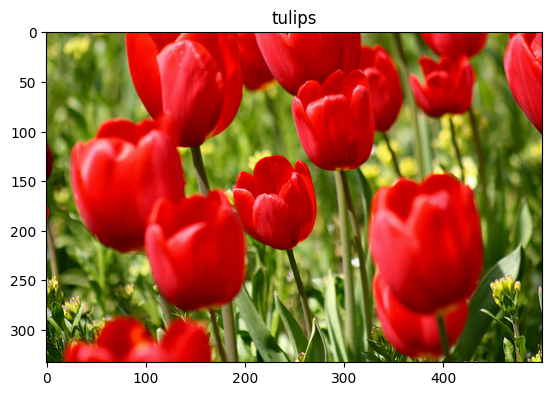

In [42]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

이전과 마찬가지로 성능을 위해 훈련, 검증 및 테스트 세트를 일괄 처리, 셔플 및 구성해야 합니다.

In [43]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

[데이터 강화](../images/data_augmentation.ipynb) 가이드를 방문하여 꽃 데이터세트 및 TensorFlow 데이터세트를 처리하는 전체 예제를 찾을 수 있습니다.